In [1]:
# https://platform.olimpiada-ai.ro/problems/40

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch import nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train = pd.read_csv("/kaggle/input/emoji-segmentation/train.csv")
test = pd.read_csv("/kaggle/input/emoji-segmentation/test.csv")

In [4]:
train['Path'] = train['Path'].map(lambda x: os.path.join('/kaggle/input/emoji-segmentation', x))
train['Mask'] = train['Mask'].map(lambda x: os.path.join('/kaggle/input/emoji-segmentation', x))

test['Path'] = test['Path'].map(lambda x: os.path.join('/kaggle/input/emoji-segmentation', x))

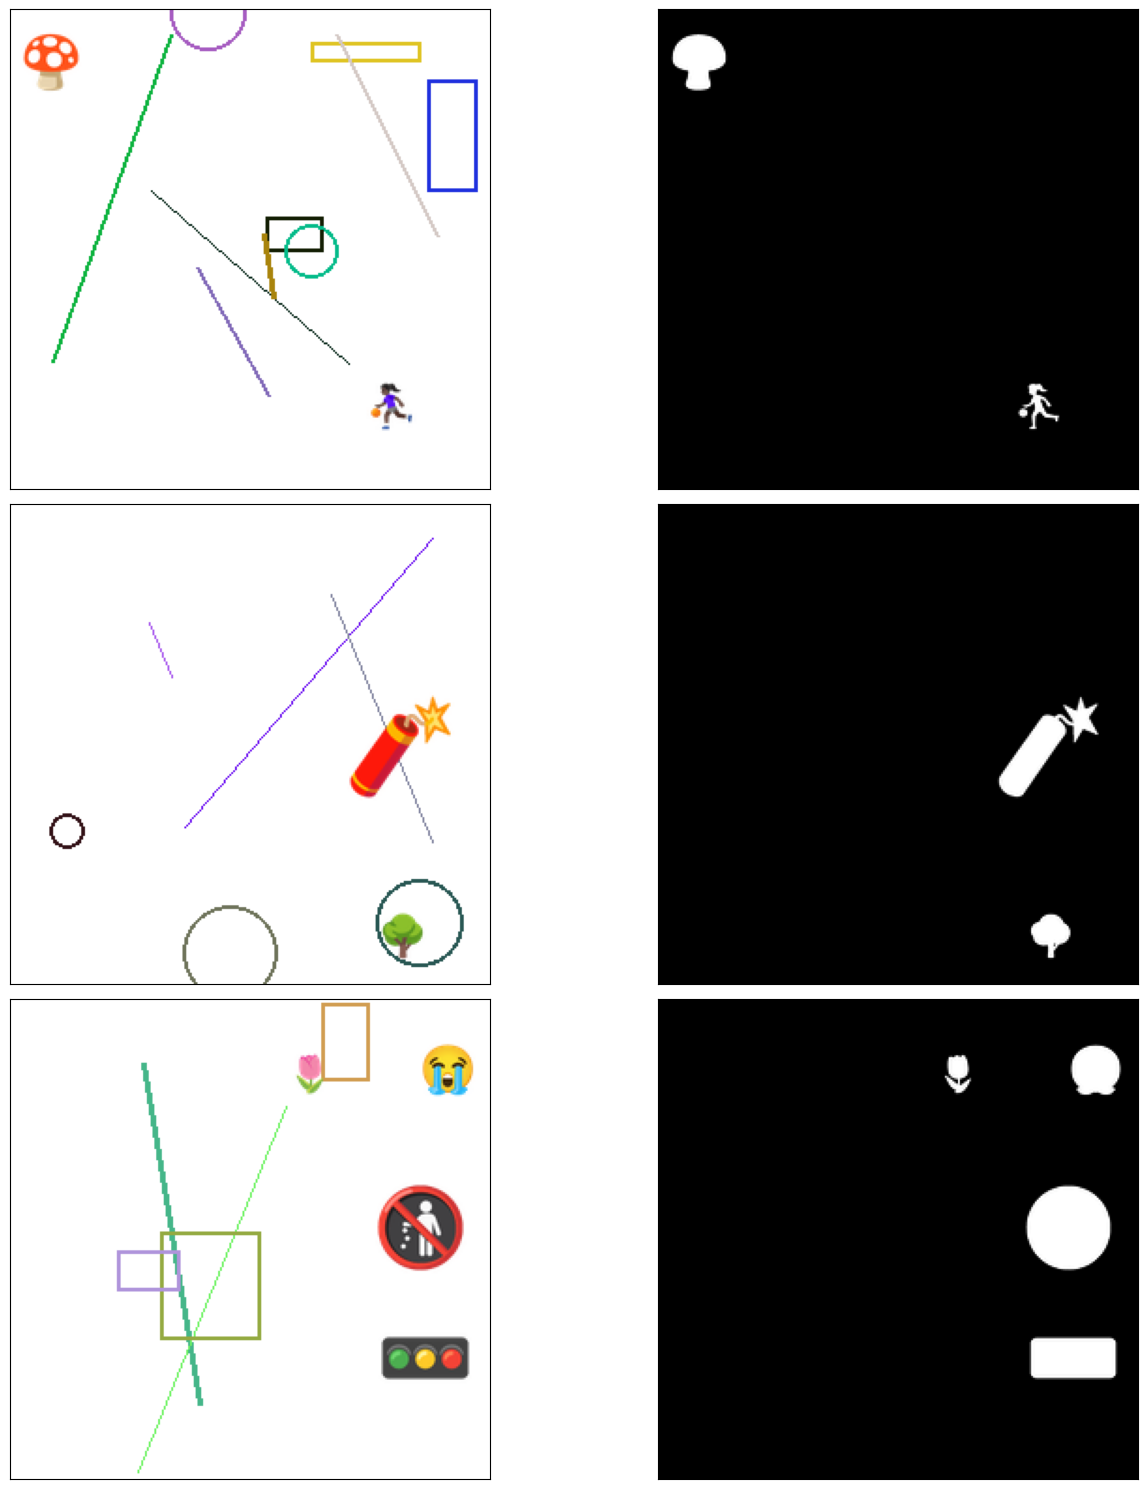

In [5]:
from PIL import Image

plt.figure(figsize=(15, 15))

n_rows = 3

for i in range(n_rows):
    plt.subplot(n_rows, 2, i*2+1)
    plt.imshow(Image.open(train['Path'][i]))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(n_rows, 2, i*2+2)
    plt.imshow(Image.open(train['Mask'][i]), cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, random_state=42, test_size=0.2)
train.reset_index(inplace=True, drop=True)
valid.reset_index(inplace=True, drop=True)

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class EmojiDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        input_img, target_img = Image.open(self.df['Path'][idx]), None
        if 'Mask' in self.df.columns:
            target_img = Image.open(self.df['Mask'][idx])
        if self.transform is not None:
            input_img = self.transform(input_img)
            if target_img is not None:
                target_img = self.transform(target_img)
                target_img = (target_img > 0).type(torch.float32)
        if target_img is not None:
            return input_img, target_img
        return input_img

transform = transforms.Compose([
    transforms.ToTensor()
])

BATCH_SIZE = 16

train_ds = EmojiDataset(train, transform)
valid_ds = EmojiDataset(valid, transform)
test_ds = EmojiDataset(test, transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.pool = nn.MaxPool2d(2)
        self.enc1 = self.enc_block(in_channels, 16)
        self.enc2 = self.enc_block(16, 64)
        self.enc3 = self.enc_block(64, 256)
        self.enc4 = self.enc_block(256, 1024)

        self.mid = self.bottle_neck(1024, 2048)

        self.dec1 = self.dec_block(1024, 1024)
        self.dec2 = self.dec_block(2048, 256)
        self.dec3 = self.dec_block(512, 64)
        self.dec4 = self.dec_block(128, 16)

        self.head = nn.Conv2d(32, out_channels, kernel_size=1)
    
    def enc_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
        )

    def bottle_neck(self, in_channels, mid_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(mid_channels),

            nn.Conv2d(mid_channels, in_channels, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(in_channels),
            nn.Dropout(0.1)
        )

    def dec_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
        )
    
    def forward(self, x):
        # x is [B, 3, 256, 256]
        x1 = self.enc1(x)  # [B, 16, 256, 256]
        x2 = self.enc2(self.pool(x1)) # [B, 64, 128, 128]
        x3 = self.enc3(self.pool(x2)) # [B, 256, 64, 64]
        x4 = self.enc4(self.pool(x3)) # [B, 1024, 32, 32]

        m = self.mid(self.pool(x4)) # [B, 1024, 16, 16]

        y4 = torch.cat([self.dec1(m), x4], dim=1) # [B, 2048, 32, 32]
        y3 = torch.cat([self.dec2(y4), x3], dim=1) # [B, 512, 64, 64]
        y2 = torch.cat([self.dec3(y3), x2], dim=1) # [B, 128, 128, 128]
        y1 = torch.cat([self.dec4(y2), x1], dim=1) # [B, 32, 256, 256]

        x = self.head(y1)
        return x

epochs = 10
log_rate = 1

model = UNet().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-3)

In [9]:
for epoch in tqdm(range(epochs), desc='Training Model'):
    model.train()
    running_train_loss = 0
    i = 0
    for X, y in (pbar := tqdm(train_loader, desc='Train DataLoader', leave=False)):
        i += 1
        X, y = X.to(device), y.to(device)
        output = model(X)
        loss = loss_fn(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        pbar.set_postfix({'loss': f"{running_train_loss/i:.5f}"})

    if (epoch+1)%log_rate==0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {running_train_loss/i:.5f}")
        
    model.eval()
    running_valid_loss = 0
    i = 0
    for X, y in (pbar := tqdm(valid_loader, desc='Valid DataLoader', leave=False)):
        i += 1
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            output = model(X)
            loss = loss_fn(output, y)

        running_valid_loss += loss.item()
        pbar.set_postfix({'loss': f"{running_valid_loss/i:.5f}"})
        
    if (epoch+1)%log_rate==0:
        print(f"Valid Loss: {running_valid_loss/i:.5f}")

Training Model:   0%|          | 0/10 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.65897


Valid DataLoader:   0%|          | 0/19 [00:00<?, ?it/s]

Valid Loss: 0.35622


Train DataLoader:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.56544


Valid DataLoader:   0%|          | 0/19 [00:00<?, ?it/s]

Valid Loss: 0.36690


Train DataLoader:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.49169


Valid DataLoader:   0%|          | 0/19 [00:00<?, ?it/s]

Valid Loss: 0.42869


Train DataLoader:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.41921


Valid DataLoader:   0%|          | 0/19 [00:00<?, ?it/s]

Valid Loss: 0.47156


Train DataLoader:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.34208


Valid DataLoader:   0%|          | 0/19 [00:00<?, ?it/s]

Valid Loss: 0.31806


Train DataLoader:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.26943


Valid DataLoader:   0%|          | 0/19 [00:00<?, ?it/s]

Valid Loss: 0.19855


Train DataLoader:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.21545


Valid DataLoader:   0%|          | 0/19 [00:00<?, ?it/s]

Valid Loss: 0.21313


Train DataLoader:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.17392


Valid DataLoader:   0%|          | 0/19 [00:00<?, ?it/s]

Valid Loss: 0.17225


Train DataLoader:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.14167


Valid DataLoader:   0%|          | 0/19 [00:00<?, ?it/s]

Valid Loss: 0.14767


Train DataLoader:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.11617


Valid DataLoader:   0%|          | 0/19 [00:00<?, ?it/s]

Valid Loss: 0.10438


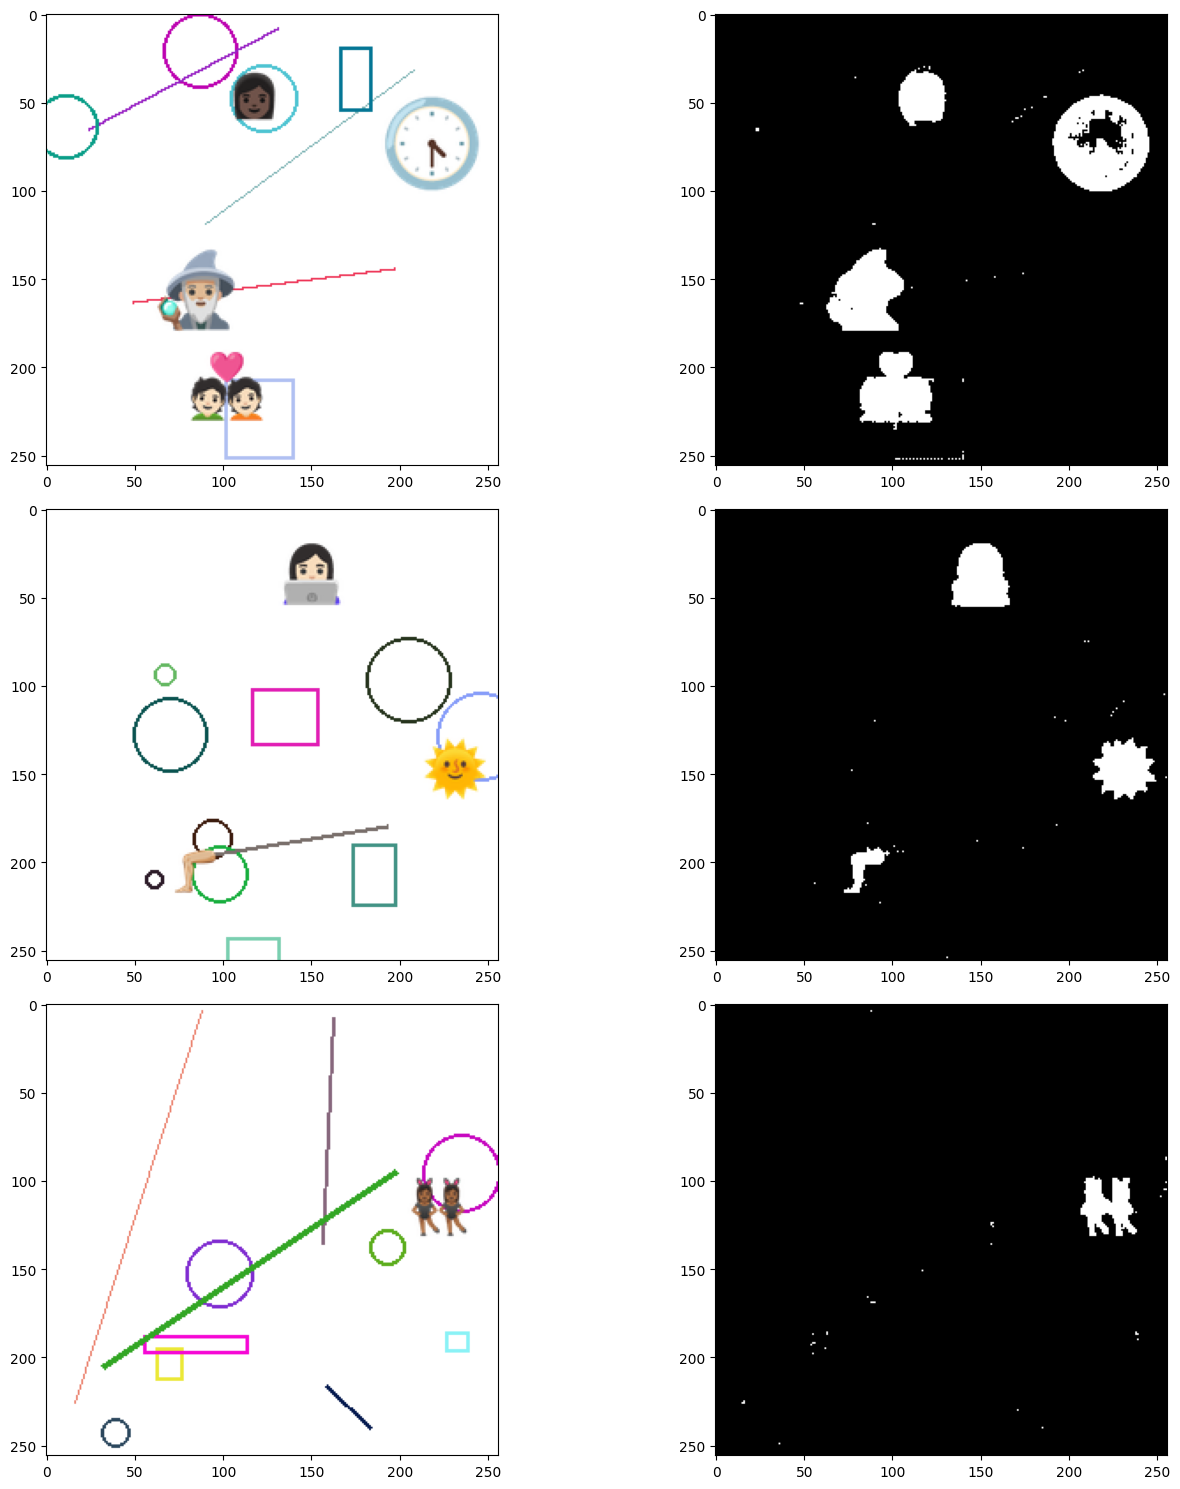

In [10]:
n_rows = 3

plt.figure(figsize=(15, 15))

test_iter = iter(test_loader)

for i in range(n_rows):
    inp = next(iter(test_iter)).to(device)
    
    with torch.no_grad():
        output = model(inp)
        output = torch.sigmoid(output)
    
    plt.subplot(n_rows, 2, i*2+1)
    plt.imshow(inp[0].permute(1, 2, 0).detach().cpu().numpy())
    
    plt.subplot(n_rows, 2, i*2+2)
    plt.imshow(((output[0].permute(1, 2, 0)>0.5).int()*255).detach().cpu().numpy(), cmap='gray')

plt.tight_layout()
plt.show()

In [11]:
import imageio.v2 as imageio

os.mkdir('submission')

paths = []

model.eval()
i = 0
for X in (pbar := tqdm(test_loader, desc='Test DataLoader')):
    i += 1
    X = X.to(device)
    with torch.no_grad():
        output = model(X)
        output = torch.sigmoid(output)
    img_to_save = (output.squeeze().cpu()>0.5).int().numpy() * 255
    img_to_save = img_to_save.astype("uint8")
    path = f"{test.loc[i-1, 'SampleID']}.png" 
    paths.append(path)
    imageio.imwrite(os.path.join('submission', path), img_to_save)

Test DataLoader:   0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
subm = pd.DataFrame({
    'SampleID': test['SampleID'],
    'PredictedMask': paths
})

subm.to_csv("submission/submission.csv", index=False)

subm

,SampleID,PredictedMask
0,test_1500,test_1500.png
1,test_1501,test_1501.png
2,test_1502,test_1502.png
3,test_1503,test_1503.png
4,test_1504,test_1504.png
...,...,...
495,test_1995,test_1995.png
496,test_1996,test_1996.png
497,test_1997,test_1997.png
498,test_1998,test_1998.png


In [13]:
import shutil

shutil.make_archive("submission", "zip", "submission")

'/kaggle/working/submission.zip'